### Prueba implementación Saliency y Activation Maps

Visualizamos cómo variaciones en los parámetros del modelo físico
impactan en las unidades del espacio latente.

La idea es calcular derivadas en las unidades del espacio latente, respecto de los parámetros del modelo físico, utilizando la regla de la cadena:
$$\frac{d \ Unit}{d \alpha} = \frac{d \ Unit}{d I}\frac{d I}{d \alpha},$$
donde $\alpha$ es un parámetro del modelo físico, en este caso SSA, e $I$ es la imagen generada a la salida de dicho modelo, en este caso un tensor de $30\times30\times3$ con cada uno de los canales de la matriz de scattering $\sigma_{pq}\left(\theta, \phi\right)$.

Comenzamos implementando saliency maps, para entender cómo las variaciones a nivel imágenes. Equivalente a calcular la primera derivada de la regla de la cadena: $\frac{d \ Unit}{d I}$. 

In [1]:
# Utilizamos el autoencoder y los pesosdesde la corrida de SSA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,3)), 
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Conv2D(4, (4, 4), strides=2, activation = 'relu'),
                                            #layers.MaxPooling2D((2, 2),strides=1, padding = 'same'),
                                            layers.Flatten(),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),
                                            layers.Dense(units = 5*5*4, activation = 'relu'),
                                            #layers.Dense(units = 5*5*4, activation = 'relu'),
                                            layers.Dense(units = 10*10*4, activation = 'relu'),
                                            
                                            layers.Reshape(target_shape=(10,10,4)),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(4, (4, 4), strides=2, activation="relu"),
                                            #layers.UpSampling2D((2, 2)),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.Conv2D(3, (4, 4), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

2022-04-12 17:53:12.004860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 17:53:12.004885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
latent_dim = 3

# Get weights path
rel_path = os.path.join(os.getcwd(), "../../results")
file_name = f"weights_lat_{latent_dim}_ssa_two_layer_ngi.h5"
weights_path = os.path.join(rel_path, file_name)

# Load model with weights
model = ConvAutoencoder(latent_dim)
model.build(input_shape=(16000,30,30,3))
model.load_weights(weights_path)

2022-04-12 17:53:15.204965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-12 17:53:15.204985: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-12 17:53:15.205002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lionelhutz): /proc/driver/nvidia/version does not exist
2022-04-12 17:53:15.205225: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Con el modelo entrenado, pasamos imágenes por el encoder y observamos la salida.

(-1.0, 1.0)

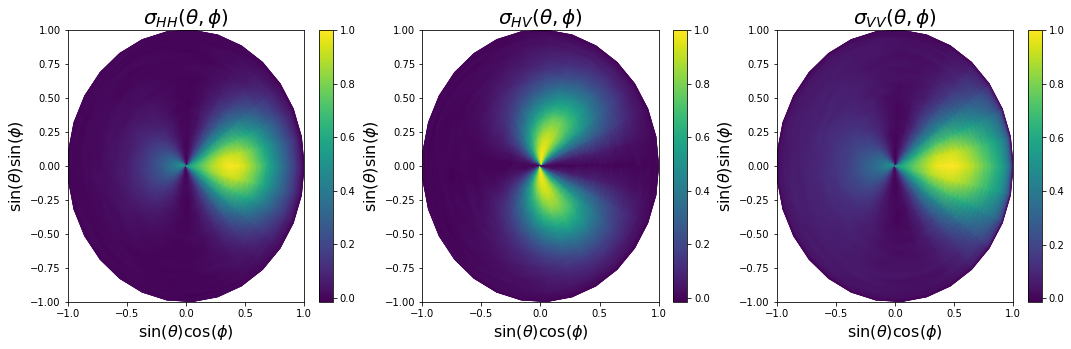

In [3]:
import pickle

from matplotlib import pyplot as plt
import numpy as np

# Prepare some input images
file_path = folder = os.getcwd().split('/')[:-2]
file_name = "results/SSA_tl_test_set.pkl"
file_path = os.path.join("/".join(folder), file_name)

with open(file_path, "rb") as f:
    sigma_test = pickle.load(f)

# Visualize random test element
rng = np.random.default_rng()
idx = rng.integers(sigma_test.shape[0])
img = sigma_test[idx, :, :, :]

# Plot domain
# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img[:,:,0],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal HV
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(kx, ky, img[:,:,1],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(1, 3, 3)
c = ax.pcolormesh(kx, ky, img[:,:,2],
                  shading = 'gouraud' )
plt.title(r'$\sigma_{VV}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))    


Definimos la función score que me selecciona qué unidad del espacio latente mirar, y el objeto Saliency, para calcular attention o saliency maps respecto de cada unidad.

In [4]:
# Create score object to select outputs
#from tf_keras_vis.utils.scores import CategoricalScore
from functools import partial    

def score_function(output, l_dim):
    return output[:, l_dim]

In [5]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

# Create Saliency object.
saliency = Saliency(model.encoder)

# Generate saliency map
saliency_map = np.array([saliency(partial(score_function, l_dim=l), seed_input=img)[0,:,:] 
                        for l in range(latent_dim)])
saliency_map.shape

2022-04-12 17:53:16.996556: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29388800 exceeds 10% of free system memory.
2022-04-12 17:53:16.999504: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29814400 exceeds 10% of free system memory.
2022-04-12 17:53:17.003399: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28189200 exceeds 10% of free system memory.
2022-04-12 17:53:17.017946: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29388800 exceeds 10% of free system memory.
2022-04-12 17:53:17.019224: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29814400 exceeds 10% of free system memory.


(3, 30, 30)

Visualizamos saliency_map

(-1.0, 1.0)

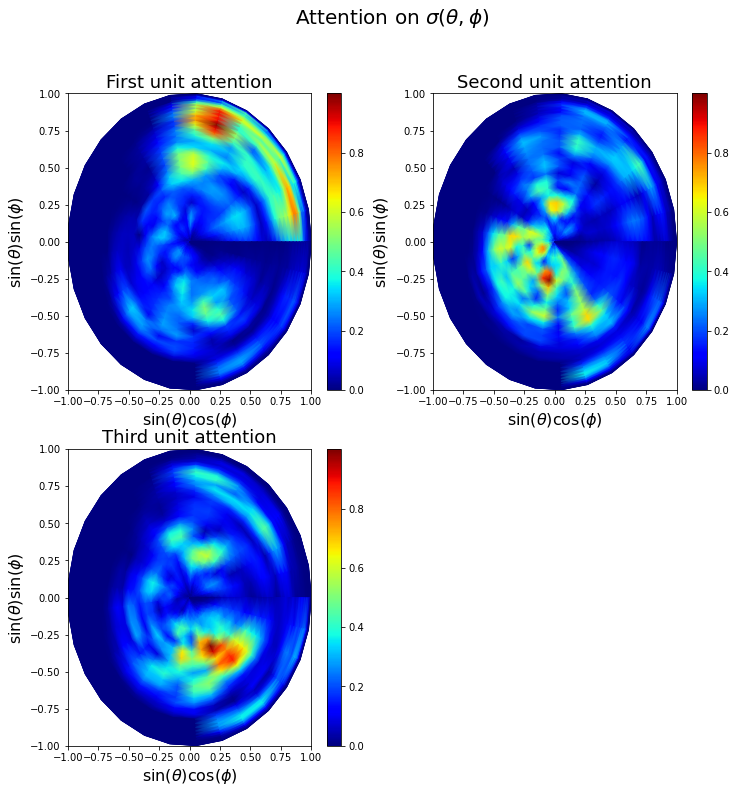

In [6]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle(r'Attention on $\sigma(\theta,\phi)$', fontsize = 20)
# Canal HH
ax = plt.subplot(2, 2, 1)
c = ax.pcolormesh(kx, ky, saliency_map[0], cmap='jet',shading = 'gouraud')
plt.title(r'First unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

#Canal HV
ax = plt.subplot(2, 2, 2)
c = ax.pcolormesh(kx, ky, saliency_map[1], cmap='jet',shading = 'gouraud')
plt.title(r'Second unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# Canal VV
ax = plt.subplot(2, 2, 3)
c = ax.pcolormesh(kx, ky, saliency_map[2], cmap='jet',shading = 'gouraud')
plt.title(r'Third unit attention', fontsize = 18)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))   

# # Canal VV
# ax = plt.subplot(2, 2, 4)
# c = ax.pcolormesh(kx, ky, saliency_map[3], cmap='jet',shading = 'gouraud')
# plt.title(r'Fourth unit attention', fontsize = 18))
# plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
# plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
# fig.colorbar(c, ax=ax)
# plt.xlim((-1,1))
# plt.ylim((-1,1))  

#### Calculamos derivadas respecto de los parámetros del modelo

Primero generamos imágenes barriendo los posibles valores de la constante dieléctrica de la primer superficie -$ \epsilon_{1} $-, fijando el resto de los parámetros del modelo en su valor mínimo.

In [8]:
from two_rough_layers import *

# Genero datos barriendo epsilon
k0 = 2*pi/.25
d = .5
ep1, ep2 = np.arange(3, 53), 3
s1, s2 = .005, .005
l1, l2 = .05, .05
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi / \
    180, np.linspace(0, 360, 30)*np.pi/180
THETA, PHI = np.meshgrid(theta, phi)

sigma = np.zeros((len(ep1), PHI.shape[0], PHI.shape[1], 3))
# Armo una tupla con los argumentos de S01
for idx, ep in enumerate(ep1):
    args = (k0, THETA, PHI,
            theta_i, phi_i,
            ep, ep2,
            s1, l1,
            s2, l2,
            d)

    # Calculo la sección eficaz y agrego ruido
    s_O1 = suma_O1(*args)
    
    # v-pol
    s_vv = s_O1[0, 0]
    s_vv_noise = s_vv + rng.normal(0, .03*np.mean(s_vv), size=PHI.shape)

    # h-pol
    s_hh = s_O1[1, 1]
    s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size=PHI.shape)

    s_hv = s_O1[1, 0]
    s_hv_noise = s_hv + rng.normal(0, .03*np.mean(s_hv), size=PHI.shape)

    # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
    # Cuenta cantidad de NaNs
    cond = np.count_nonzero(np.isnan(s_hh_noise))
    if cond == 0:
        stack = np.dstack((s_hh_noise/np.max(np.abs(s_hh_noise)),
                           s_hv_noise/np.max(np.abs(s_hv_noise)),
                           s_vv_noise/np.max(np.abs(s_vv_noise))))
        sigma[idx, :, :, :] = stack
    else:
        raise ValueError(f'Input contains NaN, infinity or a value too large for {s_hh_noise.dtype}')



In [9]:
print(sigma.shape)

(50, 30, 30, 3)


Calculamos la derivada de la matriz de scattering respecto del parámetro que acabamos de variar $\frac{d I}{d\alpha}=\frac{d\sigma}{d\epsilon_{1}}$, y multiplicamos por los Saliency Maps.

In [16]:
# Derivada respecto de epsilon 1
d_sigma = np.diff(sigma, axis=0)
size = d_sigma.shape

# Hacemos un reshape para poder contraer indices más fácil
d_sigma.resize((size[0], size[1]*size[2], size[3]))
saliency_map.resize(1, size[1]*size[2], size[3])

# Variacion de cada unidad respecto a epsilon
d_Unit = np.tensordot(saliency_map, d_sigma, axes=(1, 1))
d_Unit = np.squeeze(d_Unit, axis=0)
d_Unit.shape


(3, 49, 3)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


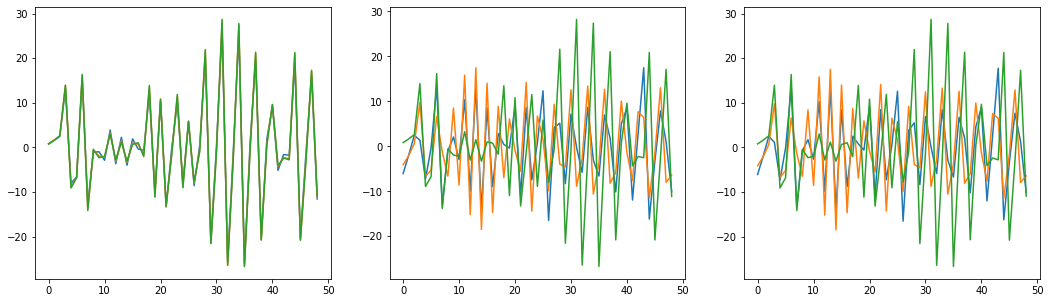

In [24]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1,3,1)
ax1.plot(range(49), d_Unit[0,:,2], label="VV")
ax1.plot(range(49), d_Unit[1,:,2], label="HH")
ax1.plot(range(49), d_Unit[2,:,2], label="HV")
ax.legend()

ax1 = plt.subplot(1,3,2)
ax1.plot(range(49), d_Unit[1,:,0], label="VV")
ax1.plot(range(49), d_Unit[1,:,1], label="HH")
ax1.plot(range(49), d_Unit[1,:,2], label="HV")
ax.legend()

ax1 = plt.subplot(1,3,3)
ax1.plot(range(49), d_Unit[2,:,0], label="VV")
ax1.plot(range(49), d_Unit[2,:,1], label="HH")
ax1.plot(range(49), d_Unit[2,:,2], label="HV")
ax.legend()